# Construction of an artificial (but realistic) image

Before we move on to looking at a real image, let's spend a few minutes getting comfortable with what each of the different sources of counts look like in an artificial image. The advantage is that we can control how much of each count source goes into the image. Looking at extreme examples can help build an understanding of what's going on in your images.

## Imports

Almost all of the notebooks in this tutorial will start with the import of the Python packages needed for that notebook. The lines below set up [matplotlib](https://matplotlib.org/), a widely used plotting package.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from photutils.aperture import EllipticalAperture

The Python file referenced below, [convenience_functions.py](convenience_functions.py), contains a few functions for convenient display of images in a notebook. Note that by clicking the above link you can read (or edit) the file in the browser. You can also read/edit it in your preferred editor, but it's handy to know that editing Python files in the Jupyter notebook environment is possible.

In [2]:
from convenience_functions import show_image

## Start: a blank image

We'll begin with the simplest possible image: an array of zeros. The dimensions of the image below are chosen to match some real images we'll be working with later.

In [3]:
synthetic_image = np.zeros([2000, 2000])

(10.0, 10)


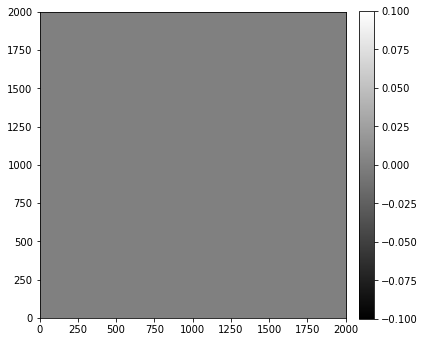

In [4]:
show_image(synthetic_image, cmap='gray')

## Add some read noise

Which each of the things we add, we'll write a small function for adding so that it's easier to experiment with different values. Read noise has a Gaussian distribution; the standard deviation of the Gaussian (in counts) is the read noise (in electrons) divided by the gain (in electrons per count). Read noise is almost always given in electrons.

Note that each time you run this function you'll get a different set of pixels so that it behaves like real noise.

In [5]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = np.random.normal(scale=amount/gain, size=shape)
    
    return noise

(10.0, 10)


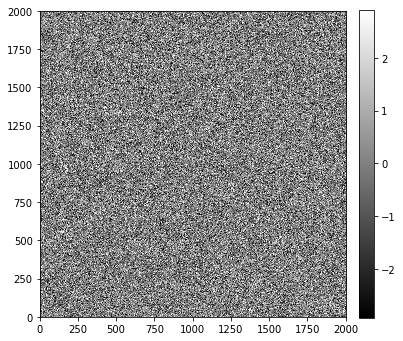

In [6]:
noise_im = synthetic_image + read_noise(synthetic_image, 5)
show_image(noise_im, cmap='gray')

##  Bias

Bias is an offset voltage (which translates into some non-zero number of counts) added to every pixel in the image to ensure that when voltages are converted to counts there is never a negative count. Note that in the noise image above, some counts are positive and some are negative, as you would expect for a Gaussian distribution centered on zero. Pixel values are typically read out from the electronics as *positive* numbers, though. Adding a constant voltage, which corresponds to a constant, positive number, ensures that even an image which consists entirely of noise has no negative values.

The bias value is roughly the same across the CCD chip, though it's not uncommon to have "bad" columns and pixels in which the bias level is consistently offset from the rest of the chip.

To model a bias image, we create a uniform array and, optionally, add in some "bad" columns. The bad columns are exaggeratesd here to ensure they are visible.

The bad columns in a CCD are typically stable over a very long time. A random number generator is used below to pick which columns in our CCD are bad, but we'll use a seed to make sure that each time we generate the bias we get the same bad columns (and pixel values within the bad columns).

This stability is what makes it possible to correct for the effect in real images.

Finally, note that the bias doesn't depend on exposure time. That's because a bias exposure is a zero-second exposure in which the camera simply reads the chip out.

In [7]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im
        

(9.0, 9)


Text(0.5, 1.0, 'Bias alone, bad columns included')

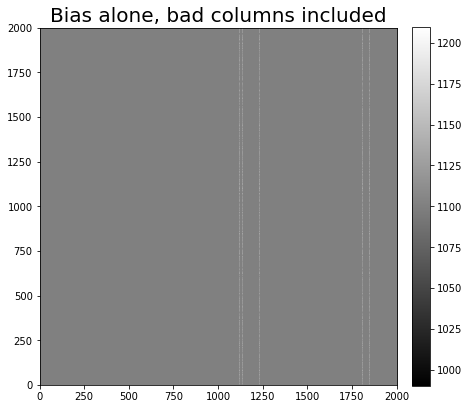

In [8]:
bias_only = bias(synthetic_image, 1100, realistic=True)
show_image(bias_only, cmap='gray', figsize=(7, 9))
plt.title('Bias alone, bad columns included', fontsize='20')

(9.0, 9)


Text(0.5, 1.0, 'Realistic bias frame (includes read noise)')

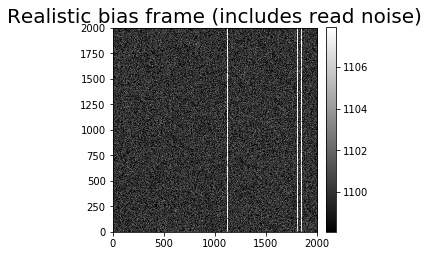

In [9]:
bias_noise_im = noise_im + bias_only
show_image(bias_noise_im, cmap='gray', figsize=(4, 9))
plt.title('Realistic bias frame (includes read noise)', fontsize='20')

## Dark current

Dark current depends on the temperature of the sensor. The amount of dark counts in an image also depends on the exposure time. Dark current is typically very small (0.1 electrons/pixel/second or less). Dark counts in this function are calculated by multiplying the input dark current by the input exposure time after converting the dark current unit from electrons to counts using the gain.

A small fraction of pixels are "hot": their dark current is much larger than the rest of the pixels. Hot pixels are modeled here by choosing a subset of the pixels to have a dark current 10,000 times larger than the input dark current. This exaggerates the effect to make those pixels more visible.

The location and current of hot pixels is typically stable over long periods of time, which makes it straightforward to remove their effect from science images by subtracting them out.

A dark frame (or dark image) is an image taken with the camera shutter closed.

The function below simulates dark current only, i.e. it does *not* simulate the read noise that is a part of any actual dark frame from a CCD.

Note that the simulation dark image looks noisy even though it doesn't include read noise. This is because the number of electrons generated obey a Poisson distribution.

In [10]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = np.random.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
    return dark_im

/Users/mcraig/conda-main/envs/ccd-guide/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(9.0, 9)


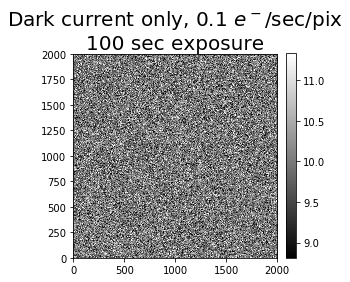

In [11]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
show_image(dark_only, cmap='gray', figsize=(4, 9))
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');

Note that the central value of the image colorbar is 10, the product of the dark current and the exposure time.

(9.0, 9)


Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

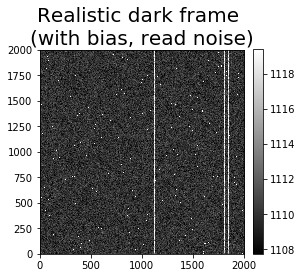

In [12]:
dark_bias_noise_im = bias_noise_im + dark_only
show_image(dark_bias_noise_im, cmap='gray', figsize=(4, 9))
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')

## Sky background

The amount of sky background depends on the atmospheric conditions (humidity, presence of light clouds, fires upwind from the observatory), the light sources in the sky (the Moon), and light sources in the surrounding area (cities). It may be uniform across the frame or it may not be, depending on the conditions.

The function below generates some sky background. Each time you run it you'll get slightly different results (even if you keep the desired amount of sky counts the same) because the counts from a light source follow a Poisson distribution.

The amount of sky background is directly proportional to the exposure time. In the function below however, you input the desired number of sky counts.

It's not at all unusual to have a gradient in the sky across the image, but that effect is not simulated here.

In [13]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = np.random.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

(9.0, 9)


Text(0.5, 1.0, 'Sky background only, 20 counts input')

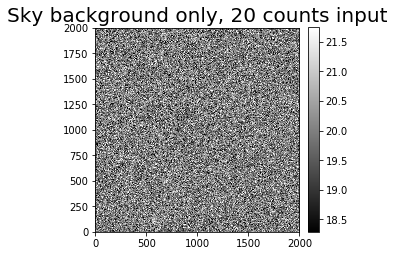

In [14]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
show_image(sky_only, cmap='gray', figsize=(4, 9))
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)

(9.0, 9)


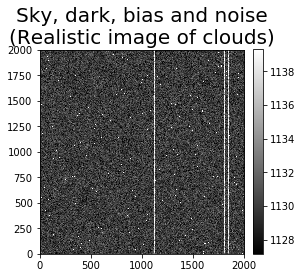

In [15]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
show_image(sky_dark_bias_noise_im, cmap='gray', figsize=(4, 9))
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20);

### Summary

Note that the central value of the pixels in the "realistic" cloud image above, 1130 or so, is the sum of the: 

+ bias level (1100 counts)
+ dark current (10 counts, which is 0.1 e/sec/pix $\times$ 100 sec, divided by the gain of 1 e/count)
+ sky counts (20 counts)

The distribution of counts around that is determined by the read noise (5 electrons) and the expected width of a Poisson distribution for the sky counts, which is the square root of the number of those counts, $\sqrt{20} \approx 4.5$. Add those in quadrature and you get about 6.7.

### Interactive demo

The cell below sets up an interactive demo that lets you change the value of read noise and other parameters to see the effect that changing them has on the resulting image.

/Users/mcraig/conda-main/envs/ccd-guide/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


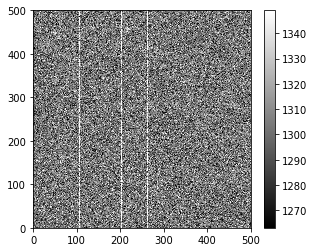

In [16]:
from ipywidgets import interactive, interact

# @interact(bias_level=(1000,1200,10), dark=(0.01,1,0.01), sky_counts=(0, 300, 10),
#           gain=(0.5, 3.0, 0.1), read=(0, 50, 2.0),
#           exposure=(0, 300, 10))
def complete_image(bias_level=1100, read=10.0, gain=1, dark=0.1, 
                   exposure=30, hot_pixels=True, sky_counts=200):
    synthetic_image = np.zeros([500, 500])
    show_image(synthetic_image + 
               read_noise(synthetic_image, read) +
               bias(synthetic_image, bias_level, realistic=True) + 
               dark_current(synthetic_image, dark, exposure, hot_pixels=hot_pixels) +
               sky_background(synthetic_image, sky_counts),
               cmap='gray',
               figsize=None)
    
i = interactive(complete_image, bias_level=(1000,1200,10), dark=(0.0,1,0.1), sky_counts=(0, 300, 50),
          gain=(0.5, 3.0, 0.25), read=(0, 50, 5.0),
          exposure=(0, 300, 30))

for kid in i.children:
    try:
        kid.continuous_update = False
    except KeyError:
        pass
i

## Add some "stars"

The "stars" we'll add below are essentially just (round) Gaussian sources. The function that does most of the work is from [photutils](https://photutils.readthedocs.io/en/stable/index.html), which we'll return to later for doing photometry.



In [17]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
    # Most of the code below is a direct copy/paste from
    # https://photutils.readthedocs.io/en/stable/_modules/photutils/datasets/make.html#make_100gaussians_image
    
    flux_range = [max_counts/10, max_counts]
    
    y_max, x_max = image.shape
    xmean_range = [0.1 * x_max, 0.9 * x_max]
    ymean_range = [0.1 * y_max, 0.9 * y_max]
    xstddev_range = [4, 4]
    ystddev_range = [4, 4]
    params = dict([('amplitude', flux_range),
                  ('x_mean', xmean_range),
                  ('y_mean', ymean_range),
                  ('x_stddev', xstddev_range),
                  ('y_stddev', ystddev_range),
                  ('theta', [0, 2*np.pi])])

    sources = make_random_gaussians_table(number, params,
                                          random_state=12345)
    
    star_im = make_gaussian_sources_image(image.shape, sources)
    
    return star_im

(9.0, 9)


Text(0.5, 1.0, 'Stars only')

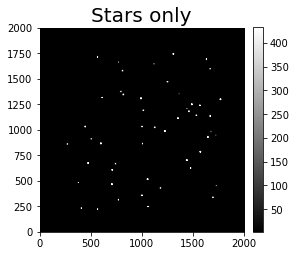

In [18]:
stars_only = stars(synthetic_image, 50, max_counts=2000)
show_image(stars_only, cmap='gray', figsize=(4, 9), percu=99.9)
plt.title('Stars only'.format(stars_only), fontsize=20)

In [19]:
stars_with_background = sky_dark_bias_noise_im + stars_only

(9.0, 9)


Text(0.5, 1.0, 'Stars with noise, bias, dark, sky')

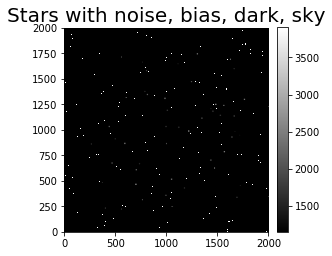

In [20]:
show_image(stars_with_background, cmap='gray', figsize=(4, 9), percu=99.9)
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)

### Discussion

In the image above the single-pixel bright dots are hot pixels while the remaining dots that are larger than a pixel are simulated stars.

## Summary

Everything we have included so far has been additive. Symbolically, the simulated image above was built like this:

$$
\text{image} = \text{bias} + \text{noise} + \text{dark current} + \text{sky} + \text{stars}
$$

Extracting the science (i.e. the stars) is in principle a matter of subtraction:

$$
\text{stars} =  \text{image} - \text{bias} - \text{noise} - \text{dark current} - \text{sky} 
$$

There are a few complications:

1. There are multiplicative effects that will be discussed in the next notebook.
2. The way to measure each of the the things we need to subtract (bias and dark current) is to take images, each of which includes read noise. That can be minimized by combining several calibration images.
3. There is no way to subtract the read noise because it is random.